In [ ]:
import json
import time
import csv
import re
import math
from tqdm.auto import tqdm
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
from tokenizers import normalizers as _normalizers
from sentence_transformers import SentenceTransformer, util
import pandas as pd
from pathlib import Path

# Инициализация SentenceTransformer для оценки
sentence_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Нормализация для сравнения
def normalize_for_compare(text):
    if text is None:
        return ""
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()
    return text

# Нормализация для обучения токенизатора
def normalize_for_tokenizer(text):
    if text is None:
        return ""
    # Заменим переносы строк на пробелы
    t = text.replace("\n", " ").strip()
    return t


d:\VSCode\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Путь к файлу корпуса
CORPUS_PATH = "3_news_corpus_universal.jsonl"

def read_corpus(path=CORPUS_PATH, max_articles=None):
    texts = []
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"Файл {path} не найден")
    with path.open("r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if max_articles is not None and i >= max_articles:
                break
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
            except Exception:
                continue
            title = rec.get("title", "")
            text = rec.get("text", "")
            combined = f"{title} {text}".strip()
            if combined:
                texts.append(normalize_for_tokenizer(combined))
    return texts

texts = read_corpus(CORPUS_PATH)
print(f"Загружено статей: {len(texts)}")
if len(texts) > 0:
    print("Пример (первые 300 символов):\n", texts[0][:300])


Загружено статей: 1000
Пример (первые 300 символов):
 <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском бою принимают участие тяжелые калибры. раннего утра <NUM> сентября огонь достиг значительного напря


In [13]:
prepared_path = "prepared_corpus_for_subword.txt"
with open(prepared_path, "w", encoding="utf-8") as fw:
    for t in texts:
        fw.write(t.replace("\n", " ").strip() + "\n")
print("Подготовлен файл:", prepared_path)


Подготовлен файл: prepared_corpus_for_subword.txt


In [ ]:
def train_subword_model(corpus_file, model_type="bpe", vocab_size=16000, min_frequency=2, show_progress=True):
    """
    model_type: 'bpe', 'wordpiece', 'unigram'
    Возвращает обучённый объект Tokenizer (tokenizers.Tokenizer)
    """
    if model_type == "bpe":
        model = models.BPE()
        trainer = trainers.BpeTrainer(vocab_size=vocab_size, min_frequency=min_frequency, show_progress=show_progress)
    elif model_type == "wordpiece":
        model = models.WordPiece(unk_token="[UNK]")
        trainer = trainers.WordPieceTrainer(vocab_size=vocab_size, min_frequency=min_frequency, show_progress=show_progress)
    elif model_type == "unigram":
        model = models.Unigram()
        trainer = trainers.UnigramTrainer(vocab_size=vocab_size, unk_token="[UNK]", show_progress=show_progress)
    else:
        raise ValueError("Unknown model_type")

    tokenizer = Tokenizer(model)
    # Простая предтокенизация - пробелы
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    # Обучаем из файла
    tokenizer.train([corpus_file], trainer=trainer)
    return tokenizer


In [ ]:
def find_unk_id(tokenizer):
    # Попробуем стандартные обозначения
    for cand in ("[UNK]", "<unk>", "[unk]", "<UNK>"):
        try:
            tid = tokenizer.token_to_id(cand)
            if tid is not None:
                return tid
        except Exception:
            pass
    # Если нет, попробуем None
    return None

def decode_ids_safe(tokenizer, ids):
    try:
        return tokenizer.decode(ids)
    except Exception:
        # fallback: join tokens
        try:
            toks = [tokenizer.id_to_token(i) for i in ids]
            return " ".join(toks)
        except Exception:
            return ""


In [16]:
from time import perf_counter

def compute_metrics_for_tokenizer(tokenizer, texts, sample_limit=None):
    """
    texts: iterable of strings
    Возвращает dict с метриками:
      - fragmentation_rate (%)  - доля слов, разбитых на 2+ subtoken
      - compression_ratio       - total_subtokens / total_words
      - reconstruction_cosine   - avg cosine similarity *100
      - reconstruction_exact    - % точно совпадающих (после normalize_for_compare)
      - vocab_size
      - oov_rate (%)            - доля слов, содержащих [UNK] при кодировании
      - avg_subtokens_per_word
      - avg_tokens_per_article
      - tokenization_time_total (s)
      - avg_tokenization_time_per_article (s)
    """
    unk_id = find_unk_id(tokenizer)
    total_words = 0
    total_subtokens = 0
    fragmented_words = 0
    oov_words = 0
    reconstruction_cosines = []
    reconstruction_exact_count = 0
    article_token_counts = []
    tokenization_time = 0.0

    texts_iter = texts if sample_limit is None else texts[:sample_limit]

    for text in tqdm(texts_iter, desc="scoring texts"):
        t0 = perf_counter()
        encoded = tokenizer.encode(text)
        t1 = perf_counter()
        tokenization_time += (t1 - t0)

        tokens = encoded.tokens
        ids = encoded.ids
        article_token_counts.append(len(tokens))
        total_subtokens += len(tokens)

        # слова (наивно)
        words = text.split()
        total_words += len(words)

        # фрагментация и OOV по словам
        for word in words:
            enc_w = tokenizer.encode(word)
            w_ids = enc_w.ids
            w_tokens = enc_w.tokens
            if len(w_tokens) > 1:
                fragmented_words += 1
            if unk_id is not None and unk_id in w_ids:
                oov_words += 1

        # реконструкция: cosine similarity и точное совпадение (нормализованно)
        decoded = decode_ids_safe(tokenizer, ids)
        s_orig = normalize_for_compare(text)
        s_dec = normalize_for_compare(decoded)
        # cosine similarity
        try:
            emb = sentence_model.encode([s_orig, s_dec], convert_to_tensor=True)
            cos = util.cos_sim(emb[0], emb[1]).item()
        except Exception:
            cos = 0.0
        reconstruction_cosines.append(cos)
        if s_orig == s_dec:
            reconstruction_exact_count += 1

    fragmentation_rate = (fragmented_words / total_words * 100) if total_words else 0.0
    oov_rate = (oov_words / total_words * 100) if total_words else 0.0
    avg_subtokens_per_word = (total_subtokens / total_words) if total_words else 0.0
    compression_ratio = (total_subtokens / total_words) if total_words else 1.0
    reconstruction_cosine_avg = (sum(reconstruction_cosines) / len(reconstruction_cosines) * 100) if reconstruction_cosines else 0.0
    reconstruction_exact_pct = (reconstruction_exact_count / len(texts_iter) * 100) if len(texts_iter) else 0.0
    avg_tokens_per_article = (sum(article_token_counts) / len(article_token_counts)) if article_token_counts else 0.0
    avg_time_per_article = (tokenization_time / len(article_token_counts)) if article_token_counts else 0.0

    return {
        "fragmentation_rate": fragmentation_rate,
        "oov_rate": oov_rate,
        "avg_subtokens_per_word": avg_subtokens_per_word,
        "compression_ratio": compression_ratio,
        "reconstruction_cosine_pct": reconstruction_cosine_avg,
        "reconstruction_exact_pct": reconstruction_exact_pct,
        "vocab_size": len(tokenizer.get_vocab()),
        "avg_tokens_per_article": avg_tokens_per_article,
        "tokenization_time_total_s": tokenization_time,
        "avg_tokenization_time_per_article_s": avg_time_per_article
    }


In [ ]:
def run_full_experiment(texts,
                        vocab_sizes=(8000, 16000, 20000),
                        model_types=("bpe", "wordpiece", "unigram"),
                        min_frequency=2,
                        save_tokenizers=True,
                        sample_for_metrics=None):
    """
    texts: list of articles (строк)
    sample_for_metrics: если максимум статей для оценки метрик (чтобы быстрее считать), например 500
    """
    results = []
    # Для обучения tokenizers используем подготовленный файл
    corpus_file = prepared_path

    for model_type in model_types:
        for vs in vocab_sizes:
            print(f"\n=== Training {model_type} vocab={vs} min_freq={min_frequency} ===")
            t0 = time.time()
            tokenizer = train_subword_model(corpus_file, model_type=model_type, vocab_size=vs, min_frequency=min_frequency)
            t_train = time.time() - t0

            name = f"{model_type}_vocab{vs}"
            if save_tokenizers:
                fname = f"{name}.json"
                tokenizer.save(fname)
                print(f"Saved tokenizer to {fname}")

            # Вычисляем метрики
            metrics = compute_metrics_for_tokenizer(tokenizer, texts, sample_limit=sample_for_metrics)
            metrics.update({
                "model": name,
                "model_type": model_type,
                "vocab_size": vs,
                "training_time_s": t_train,
                "time_per_1000_articles_s": (t_train / len(texts)) * 1000 if texts else None
            })
            results.append(metrics)

            # пара примеров
            if texts:
                enc = tokenizer.encode(texts[0])
                dec = decode_ids_safe(tokenizer, enc.ids)
                print(f"Example orig[:200]: {texts[0][:200]}")
                print(f"Example dec[:200]:  {dec[:200]}")
                print("Metrics (partial): fragmentation {:.2f}%  oov {:.2f}%  vocab {}".format(
                    metrics["fragmentation_rate"], metrics["oov_rate"], metrics["vocab_size"]
                ))
    return results

# Запуск
results = run_full_experiment(texts, vocab_sizes=(8000,16000,32000), model_types=("bpe","wordpiece","unigram"),
                              min_frequency=2, save_tokenizers=True, sample_for_metrics=500)
print("\nЭксперимент завершён")



=== Training bpe vocab=8000 min_freq=2 ===
Saved tokenizer to bpe_vocab8000.json


scoring texts: 100%|██████████| 500/500 [01:11<00:00,  7.03it/s]


Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < NUM >. русские войска вступи ли пределы вен г рии бои со по ц кина дру ск ени к закончи лись отступ лением герман цев . не прия тель , прибли зи вшись се вера о сов цу начал артиллерий скую борьбу к
Metrics (partial): fragmentation 55.80%  oov 0.00%  vocab 8000

=== Training bpe vocab=16000 min_freq=2 ===
Saved tokenizer to bpe_vocab16000.json


scoring texts: 100%|██████████| 500/500 [01:17<00:00,  6.47it/s]


Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < NUM >. русские войска вступи ли пределы венг рии бои со по ц кина дру ск ени к закончились отступ лением герман цев . неприятель , приблизи вшись севера о сов цу начал артиллерий скую борьбу кре по 
Metrics (partial): fragmentation 42.95%  oov 0.00%  vocab 16000

=== Training bpe vocab=32000 min_freq=2 ===
Saved tokenizer to bpe_vocab32000.json


scoring texts: 100%|██████████| 500/500 [01:14<00:00,  6.72it/s]


Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < NUM >. русские войска вступили пределы венгрии бои со по ц кина дру ск ени к закончились отступ лением герман цев . неприятель , приблизи вшись севера о сов цу начал артиллерий скую борьбу кре по ст
Metrics (partial): fragmentation 35.22%  oov 0.00%  vocab 32000

=== Training wordpiece vocab=8000 min_freq=2 ===
Saved tokenizer to wordpiece_vocab8000.json


scoring texts: 100%|██████████| 500/500 [01:22<00:00,  6.05it/s]


Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < NUM >. русские войска вступ ##или пределы вен ##гр ##ии бо ##и со ##по ##ц ##кина дру ##ске ##ник законч ##ились отступ ##лением герман ##цев . неприят ##ель , приблиз ##ившись север ##а ос ##ов ##ц
Metrics (partial): fragmentation 57.20%  oov 0.00%  vocab 8000

=== Training wordpiece vocab=16000 min_freq=2 ===
Saved tokenizer to wordpiece_vocab16000.json


scoring texts: 100%|██████████| 500/500 [01:23<00:00,  5.99it/s]


Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < NUM >. русские войска вступил ##и пределы венгр ##ии бои соп ##оц ##кина дру ##ске ##ник закончились отступ ##лением герман ##цев . неприятель , приблиз ##ившись севера ос ##ов ##цу начал артиллерий
Metrics (partial): fragmentation 44.41%  oov 0.00%  vocab 16000

=== Training wordpiece vocab=32000 min_freq=2 ===
Saved tokenizer to wordpiece_vocab32000.json


scoring texts: 100%|██████████| 500/500 [01:16<00:00,  6.56it/s]


Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < NUM >. русские войска вступили пределы венгрии бои соп ##оц ##кина дру ##ске ##ник закончились отступ ##лением герман ##цев . неприятель , приблиз ##ившись севера ос ##ов ##цу начал артиллерий ##ску
Metrics (partial): fragmentation 35.44%  oov 0.00%  vocab 32000

=== Training unigram vocab=8000 min_freq=2 ===
Saved tokenizer to unigram_vocab8000.json


scoring texts: 100%|██████████| 500/500 [01:17<00:00,  6.46it/s]


Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < N U M > . русски е войска вступил и предел ы венгри и бо и со по цк и на др у ске ник закончи лись отступлени ем гер ман цев . не при я тель , приблизи вшись север а ос ов ц у начал артиллерийск ую 
Metrics (partial): fragmentation 68.37%  oov 0.00%  vocab 8000

=== Training unigram vocab=16000 min_freq=2 ===
Saved tokenizer to unigram_vocab16000.json


scoring texts: 100%|██████████| 500/500 [01:16<00:00,  6.57it/s]


Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < N U M > . русски е войска вступил и предел ы венгри и бои со по цкин а др у ске ник закончи лись отступлени ем герман цев . неприятель , приблизи вшись север а ос ов цу начал артиллерийск ую борьб у
Metrics (partial): fragmentation 65.36%  oov 0.00%  vocab 16000

=== Training unigram vocab=32000 min_freq=2 ===
Saved tokenizer to unigram_vocab32000.json


scoring texts: 100%|██████████| 500/500 [01:16<00:00,  6.56it/s]

Example orig[:200]: <NUM>. русские войска вступили пределы венгрии бои сопоцкина друскеник закончились отступлением германцев. неприятель, приблизившись севера осовцу начал артиллерийскую борьбу крепостью. артиллерийском
Example dec[:200]:  < N U M > . русски е войска вступил и предел ы венгри и бои со по цкин а дру ске ник закончи лись отступлени ем герман цев . неприятель , приблизи вшись север а осов цу начал артиллерийск ую борьб у к
Metrics (partial): fragmentation 65.15%  oov 0.00%  vocab 32000

Эксперимент завершён


In [18]:
def save_results_csv(results, csv_path="subword_metrics.csv"):
    df = pd.DataFrame(results)
    # Приведение некоторых числовых колонок к удобному формату
    df.to_csv(csv_path, index=False, float_format="%.4f")
    print("Saved CSV:", csv_path)
    return df

def save_report_md(results, md_path="subword_report.md"):
    md = "# Отчёт по сравнительному анализу подсловных токенизаторов\n\n"
    md += f"Корпус: {CORPUS_PATH}\n"
    md += f"Модели: BPE, WordPiece, Unigram. Даты запуска эксперимента: {time.asctime()}\n\n"
    md += "| model | model_type | vocab_size | vocab_size_actual | fragmentation_% | oov_% | avg_subtokens_per_word | compression_ratio | reconstruction_cosine_% | reconstruction_exact_% | training_time_s | time_per_1000_articles_s |\n"
    md += "|---|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:|\n"
    for r in results:
        md += "| {model} | {model_type} | {vocab_size} | {vocab_size_actual:.0f} | {fragmentation_rate:.2f} | {oov_rate:.2f} | {avg_subtokens_per_word:.3f} | {compression_ratio:.3f} | {reconstruction_cosine_pct:.2f} | {reconstruction_exact_pct:.2f} | {training_time_s:.2f} | {time_per_1000_articles_s:.2f} |\n".format(
            model=r["model"],
            model_type=r["model_type"],
            vocab_size=r["vocab_size"],
            vocab_size_actual=r["vocab_size"],
            fragmentation_rate=r["fragmentation_rate"],
            oov_rate=r["oov_rate"],
            avg_subtokens_per_word=r["avg_subtokens_per_word"],
            compression_ratio=r["compression_ratio"],
            reconstruction_cosine_pct=r["reconstruction_cosine_pct"],
            reconstruction_exact_pct=r["reconstruction_exact_pct"],
            training_time_s=r["training_time_s"],
            time_per_1000_articles_s=r["time_per_1000_articles_s"] if r["time_per_1000_articles_s"] is not None else 0.0
        )
    with open(md_path, "w", encoding="utf-8") as f:
        f.write(md)
    print("Saved Markdown report:", md_path)

df_results = save_results_csv(results)
save_report_md(results)
df_results


Saved CSV: subword_metrics.csv
Saved Markdown report: subword_report.md


,fragmentation_rate,oov_rate,avg_subtokens_per_word,compression_ratio,reconstruction_cosine_pct,reconstruction_exact_pct,vocab_size,avg_tokens_per_article,tokenization_time_total_s,avg_tokenization_time_per_article_s,model,model_type,training_time_s,time_per_1000_articles_s
0,55.801646,0.0,1.906009,1.906009,80.082352,0.0,8000,288.120,0.543436,0.001087,bpe_vocab8000,bpe,0.574004,0.574004
1,42.948056,0.0,1.632452,1.632452,90.606205,0.0,16000,246.768,0.627934,0.001256,bpe_vocab16000,bpe,0.914967,0.914967
2,35.216057,0.0,1.494708,1.494708,94.701207,0.0,32000,225.946,0.607784,0.001216,bpe_vocab32000,bpe,1.015445,1.015445
3,57.196158,0.0,1.981080,1.981080,70.442162,0.0,8000,299.468,0.574230,0.001148,wordpiece_vocab8000,wordpiece,0.768416,0.768416
4,44.406076,0.0,1.686936,1.686936,82.130862,0.0,16000,255.004,0.541935,0.001084,wordpiece_vocab16000,wordpiece,0.941746,0.941746
5,35.437009,0.0,1.518470,1.518470,89.463904,0.0,32000,229.538,0.501299,0.001003,wordpiece_vocab32000,wordpiece,1.078964,1.078964
6,68.374745,0.0,2.134979,2.134979,81.983370,0.0,8000,322.732,0.977563,0.001955,unigram_vocab8000,unigram,3.310870,3.310870
7,65.359477,0.0,1.977389,1.977389,85.114801,0.0,16000,298.910,1.039581,0.002079,unigram_vocab16000,unigram,2.194927,2.194927
8,65.150433,0.0,1.964952,1.964952,85.286910,0.0,32000,297.030,1.090958,0.002182,unigram_vocab32000,unigram,1.095271,1.095271


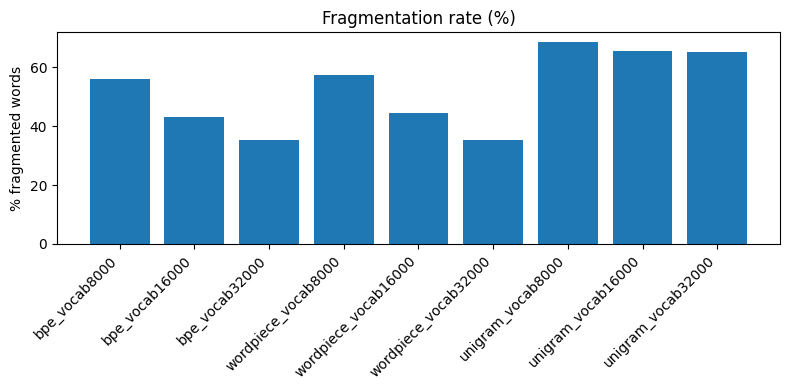

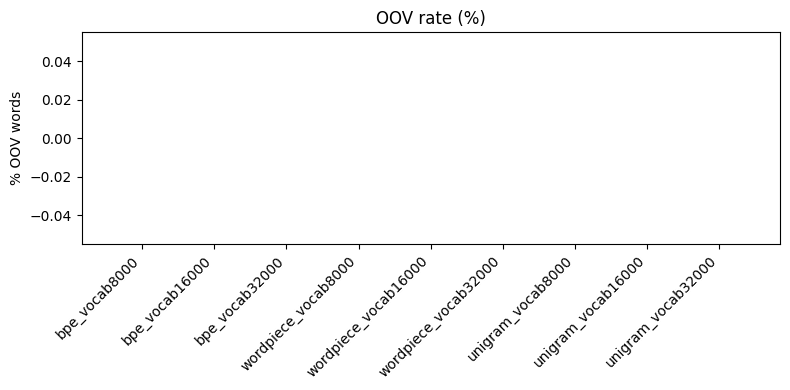

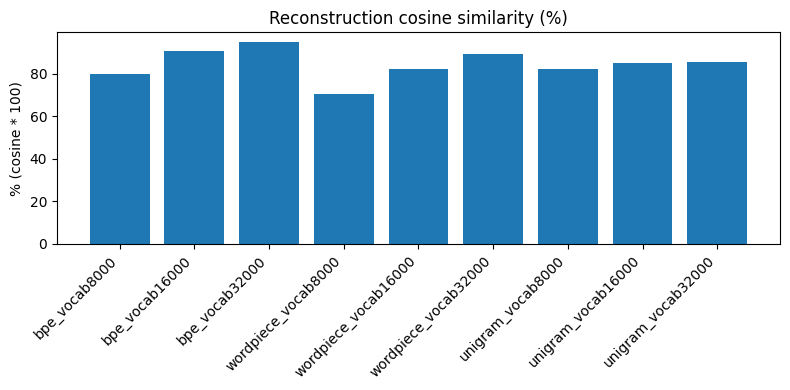

In [ ]:
import matplotlib.pyplot as plt

# Группируем
df = df_results.copy()
df["label"] = df["model"]

# Фрагментация
plt.figure(figsize=(8,4))
plt.bar(df["label"], df["fragmentation_rate"])
plt.xticks(rotation=45, ha="right")
plt.title("Fragmentation rate (%)")
plt.ylabel("% fragmented words")
plt.tight_layout()
plt.show()

# OOV
plt.figure(figsize=(8,4))
plt.bar(df["label"], df["oov_rate"])
plt.xticks(rotation=45, ha="right")
plt.title("OOV rate (%)")
plt.ylabel("% OOV words")
plt.tight_layout()
plt.show()

# Reconstruction cosine %
plt.figure(figsize=(8,4))
plt.bar(df["label"], df["reconstruction_cosine_pct"])
plt.xticks(rotation=45, ha="right")
plt.title("Reconstruction cosine similarity (%)")
plt.ylabel("% (cosine * 100)")
plt.tight_layout()
plt.show()
